In [1]:
from os import listdir
import jsonlines
import sklearn
import itertools
from tqdm import tqdm
from tqdm import trange
from sklearn.preprocessing import MultiLabelBinarizer
import re
import nltk
import pymorphy2 as pm
import networkx as nx

tknzr = nltk.TweetTokenizer()
#nltk.download()

## Достаём связи между категориями
(node_2_id) $\rightarrow$ (node_1_id)

In [2]:
links = [link for link in tqdm(jsonlines.open('links/link_directed.txt', 'r'))]

719813it [00:05, 128792.74it/s]


In [3]:
categories_id_dict = {}
for link in tqdm(links):
    categories_id_dict[link['node_1_id']] = link['node_1_title']
    categories_id_dict[link['node_2_id']] = link['node_2_title']

100%|██████████████████████████████████████████████████████████████████████| 719813/719813 [00:01<00:00, 716111.65it/s]


In [4]:
categories_forest = nx.DiGraph()
categories_forest.add_edges_from([(link['node_2_id'], link['node_1_id']) for link in links])

print("Number of nodes:", categories_forest.number_of_nodes())
print("Number of edges:", categories_forest.number_of_edges())
print("Is it a forest?", nx.is_forest(categories_forest))
print("Connected components:", nx.number_weakly_connected_components(categories_forest))

Number of nodes: 344614
Number of edges: 719389
Is it a forest? False
Connected components: 58


In [14]:
components = list(nx.weakly_connected_component_subgraphs(categories_forest))

In [15]:
for c in components:
    roots = []
    for node in list(c.nodes):
        if len(list(c.predecessors(node))) == 0:
            roots.append(node)
            
    print([categories_id_dict[root] for root in roots])
            

['Категория:Всё', 'Категория:Футбол в Арубе ', 'Категория:Википедия:Переименованные категории со статьями', 'Категория:Википедия:Перевод', 'Категория:Википедия:Проблемы с шаблонами', 'Категория:Избранные статьи по проектам', 'Категория:Хорошие статьи по проектам', 'Категория:Статьи проекта Подводные лодки по уровню', 'Категория:Статьи проекта Подводные лодки по важности', 'Категория:Википедия:Статьи с утверждениями без источников', 'Категория:Незавершённые статьи о вооруженных силах Третьего рейха', 'Категория:Статьи проекта Санкт-Петербург по качеству', 'Категория:Статьи проекта Речное пароходство по уровню', 'Категория:Статьи проекта Речное пароходство по важности', 'Категория:Статьи проекта Современное искусство по уровню', 'Категория:Статьи проекта Современное искусство по важности', 'Категория:Статьи проекта Наука по качеству', 'Категория:Статьи проекта Территории с нечётким правовым статусом по качеству', 'Категория:Статьи проекта Фармация по уровню', 'Категория:Статьи проекта Фа


['Категория:Статьи проекта Россия II уровня']
['Категория:Статьи проекта Наука по качеству и важности']
['Категория:Статьи проекта История России неизвестного уровня']
['Категория:Статьи проекта Русский рок I уровня']
['Категория:Статьи проекта Дания II уровня']
['Категория:Статьи проекта Монголия низкой важности']
['Категория:Статьи проекта История России I уровня']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Категория:Хорошие статьи проекта История России']
['Категория:Избранные статьи проекта История России']
['Категория:Статьи проекта Военная история II уровня']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Категория:Статьи проекта Антарктика II уровня']
['Категория:Статьи проекта Антарктика III уровня']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [19]:
for i in range(len(components)):
    print(i)
    print("Number of nodes:", components[i].number_of_nodes())
    print("Number of edges:", components[i].number_of_edges())

0
Number of nodes: 344531
Number of edges: 719318
1
Number of nodes: 6
Number of edges: 5
2
Number of nodes: 2
Number of edges: 1
3
Number of nodes: 4
Number of edges: 3
4
Number of nodes: 4
Number of edges: 3
5
Number of nodes: 2
Number of edges: 1
6
Number of nodes: 2
Number of edges: 1
7
Number of nodes: 4
Number of edges: 3
8
Number of nodes: 1
Number of edges: 1
9
Number of nodes: 1
Number of edges: 1
10
Number of nodes: 1
Number of edges: 1
11
Number of nodes: 1
Number of edges: 1
12
Number of nodes: 1
Number of edges: 1
13
Number of nodes: 1
Number of edges: 1
14
Number of nodes: 1
Number of edges: 1
15
Number of nodes: 1
Number of edges: 1
16
Number of nodes: 1
Number of edges: 1
17
Number of nodes: 1
Number of edges: 1
18
Number of nodes: 1
Number of edges: 1
19
Number of nodes: 1
Number of edges: 1
20
Number of nodes: 1
Number of edges: 1
21
Number of nodes: 1
Number of edges: 1
22
Number of nodes: 2
Number of edges: 2
23
Number of nodes: 1
Number of edges: 1
24
Number of nod

### Поняли, что нас интересует только первая компонента, где есть Категория:Всё

In [65]:
root = 0
for id, title in categories_id_dict.items():
    if title == 'Категория:Всё':
        print(id)
        root = id
        break
        
for id, title in categories_id_dict.items():
    if title == 'Категория:Википедия:Служебные':
        print(id)
        components[0].remove_node(id)
        break

16350
7938


In [66]:
class BuldTaxonomy():
    def __init__(self, graph, root):
        self.original_graph = graph
        self.output_graph = nx.DiGraph()
        self.stack = [root]
        
    '''
    def build_graph_recursive(self, node):
        successors = list(self.original_graph.successors(node))
        if len(successors) == 0:
            return
        else:
            for pred in successors:
                self.output_graph.add_edge(node, succ)
                self.buld_graph_recursive(succ)
    '''
    
    def build_graph(self):
        while self.stack:
            node = self.stack.pop()
            successors = list(self.original_graph.successors(node))
            for succ in successors:
                self.output_graph.add_edge(node, succ)
                self.stack.append(succ)   

In [67]:
taxonomy = BuldTaxonomy(components[0], root)
taxonomy.build_graph()
cat_graph = taxonomy.output_graph

print("Number of nodes:", cat_graph.number_of_nodes())
print("Number of edges:", cat_graph.number_of_edges())

KeyboardInterrupt: 

## Собственно, анализ

In [19]:
path = listdir('c')
path = sorted(path)
path = path[:4]
print(path)

data = []
for p in path:
    with jsonlines.open('c/' + p, 'r') as f:
        for entry in f:
            data.append(entry)

['AA', 'AB', 'AD', 'AE']


In [20]:
categories_y = [d['categories'] for d in data]
categories = sorted(set(list(itertools.chain(*categories_y))))

categories_dict = {c: 0 for c in categories}
for d in data:
    for c in d['categories']:
        if categories_dict.get(c) is not None:
            categories_dict[c] += 1
            
ok = [c for c in categories if categories_dict[c] > 5 and categories_dict[c] < 5000]
categories_y = [[c for c in cy if c in ok] for cy in tqdm(categories_y)]
len(ok)

100%|██████████████████████████████████████████████████████████████████████████| 35669/35669 [00:13<00:00, 2581.66it/s]


4781

In [21]:
y = MultiLabelBinarizer().fit_transform(categories_y)

In [24]:
words = []
texts = []
for d in tqdm(data):

    text = re.sub(r'\n+', '. ', d['text'])
    text = re.sub(r'\xa0', ' ', text)
    tokens = tknzr.tokenize(text=text)
    tokens = [t.lower() for t in tokens]     #  if t.isalnum()
    text = ' '.join(tokens)
    texts.append(text)
    words.extend(sorted(set([t for t in tokens if t.isalpha()])))

words = sorted(set(words))

  0%|                                                                                        | 0/35669 [00:00<?, ?it/s]


NameError: name 'tknzr' is not defined

In [ ]:
normal_forms = {}
for w in tqdm(words):
    nf = morph.parse(w)[0].normal_form
    normal_forms[w] = nf

In [ ]:
for i in trange(texts):
    text = texts[i]
    tokens = re.split(r' ', text)
    tokens = [normal_forms.get(t) for t in tokens if normal_forms.get(t) is not None]
    text = ' '.join(tokens)
    texts[i] = text


## Черновик
.

.

.

['B']
[('A', 'B'), ('B', 'C')]


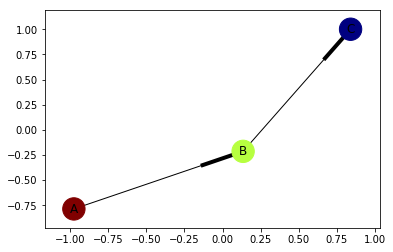

In [53]:
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_edges_from([('A','B'), ('B','C')])

print(list(G.predecessors('C')))
print(G.edges())

val_map = {'A': 1.0,
           'B': 0.5714285714285714,
           'C': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.show()

In [58]:
a = [1, 2, 4]
while a:
    print(a.pop())

4
2
1
